In [1]:
from graphviz import Digraph
import networkx as nx
from matplotlib import pyplot
import random
import pandas as pd
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.utils import plot_model
from keras import metrics
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import tensorflow as tf
import numpy as np
import sys
import io
from keras import models 
from keras import layers

# TODO: chnage 256 to a smaller number - check accuracy plots + different epochs
# TODO: hidden state calculation should be faster - can be enabled based on the need 
# or disabled if only properties of Y

Using TensorFlow backend.


In [2]:
#####################################################################
#    Parameters
#####################################################################

# input and output
sizeX = 3
sizeY = sizeX   # next character prediction


# text information
alphabet = ['c', 'a', 't', 'e', ' ']
sizeAlphabet = len(alphabet)

# human words generated by scramble game
human_words = ['cate',  'tace', 'ace',  'act',  'ate',  'cat', 'eat', 'eta', 
               'tae', 'tea', 'ae', 'at', 'et', 'ta']
n_words_in_corpus = 100000


print("Alphabet used: {}".format(alphabet))
print("Human words count : {}".format(len(human_words)))

Alphabet used: ['c', 'a', 't', 'e', ' ']
Human words count : 14


In [3]:
#####################################################################
#    Create corpus to train a model
#####################################################################
text = ''
for i in range(0, n_words_in_corpus):
    if i % 10000 == 0:
      print("i = {}".format(i))
      
    j = int(random.uniform(0, len(human_words)))
    text = text + ' ' + human_words[j]

file = open('cat_' + str(n_words_in_corpus) + '.txt', 'w')
file.write(text)
file.close()

_ = pd.Series(text.split(' '))
print("Words distribution: {}".format(_.value_counts()))

i = 0
i = 10000
i = 20000
i = 30000
i = 40000
i = 50000
i = 60000
i = 70000
i = 80000
i = 90000
Words distribution: act     7307
eta     7265
tea     7220
ace     7208
cate    7207
cat     7174
ae      7147
tae     7145
et      7116
ate     7101
tace    7092
at      7073
eat     7050
ta      6895
           1
dtype: int64


In [4]:
#####################################################################
#    Train model
#####################################################################
def sentence_to_code(sentence, char_indices, maxlen, sizeAlphabet):
  x = np.zeros((1, maxlen, sizeAlphabet))
  for t, char in enumerate(sentence):
      x[0, t, char_indices[char]] = 1.0
  return x

def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 3
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print("Chars to indices encoding: {}".format(char_indices))

# Sequential API
print('Build model...')
model = Sequential()
lstm_hunits = 32  # TODO: tune this parameter
model.add(LSTM(lstm_hunits, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[metrics.mae, metrics.categorical_accuracy])
plot_model(model, to_file='multilayer_perceptron_graph.png')

total chars: 5
nb sequences: 128689
Vectorization...


W0721 18:07:55.946543 140716208420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0721 18:07:55.977313 140716208420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0721 18:07:55.985866 140716208420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Chars to indices encoding: {' ': 0, 'a': 1, 'c': 2, 'e': 3, 't': 4}
Build model...


W0721 18:07:56.306964 140716208420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0721 18:07:56.316216 140716208420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 5,029
Trainable params: 5,029
Non-trainable params: 0
_________________________________________________________________


In [6]:
print("x size = {}".format(x.shape))
print("LSTM Layer Parameters: {}".format(4*(lstm_hunits*lstm_hunits + lstm_hunits*sizeAlphabet + lstm_hunits))) # 4*(256*256 + 5*256 + 256*1) 
print("Dense Layer Parameters: {}".format(lstm_hunits*sizeAlphabet + sizeAlphabet))  # dense 5*256 + 5
print("y size = {}".format(x.shape))

x size = (128689, 3, 5)
LSTM Layer Parameters: 4864
Dense Layer Parameters: 165
y size = (128689, 3, 5)


In [7]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

# history = funcmodel1.fit(x, [y,0.1*np.ones((128570, len(chars))), 0.1*np.ones((128570, len(chars)))], # [y, np.zeros((128570, len(chars))), np.zeros((128570, len(chars)))],#,np.zeros((128570, len(chars))),np.zeros((128570, len(chars)))],
history = model.fit(x, y,          
          batch_size=128,
          epochs=10,
          callbacks=[print_callback])

W0721 18:07:56.667905 140716208420736 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0721 18:07:57.262138 140716208420736 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/10
128689/128689 [==============================] - 12s 97us/step - loss: 0.7299 - mean_absolute_error: 0.1706 - categorical_accuracy: 0.6191

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "ae "
ae tae act tae tae tae ace tae tae tae ta at tae tae tae tae eta at tae at ta tae tae tae tae ace tae tae tae tae tae tae at tae tae tae ta at tae at tae tace tae at tae tae tae tae tae at tae tae tae tae tace tae tae tae ta ta ta at tae tae tae tae tae tace tae tae ta at tae tae tae tae tae ace tae ace tae act at tae tace ta at tae tae tae ta ta ace tae ta tae tae tae tae tace tae tae tae tae tae ta
----- diversity: 0.5
----- Generating with seed: "ae "
ae cat cat ate ace eta eta cat act at at ace eat ae tae tea tace tae tae cat tae tae act ace tae cat at tae tace ta tae eta et act tae ta at eta tae tae tea cat tae et eat tae act ta eta act act act eat tae cat ta tace cat tae tae tace ate ace tae eat ace at eat ace tea ae tae ta act at tace tace 

In [8]:
for layer in model.layers:
  print(str(layer))
  if "LSTM" in str(layer):
    weightLSTM = layer.get_weights()
    print(weightLSTM)

[array([[-1.401263  , -0.9825698 , -1.2026937 , -1.3986545 , -0.37576506,
        -0.45354438, -0.75031215, -1.0524848 , -0.39581528,  0.09171543,
        -0.25006315,  0.9889426 , -0.31330875, -0.7393571 ,  0.28945553,
         1.3468744 , -0.6481241 , -0.63211757, -1.9160448 , -0.7639768 ,
        -2.4079034 , -1.29275   , -2.1268272 , -0.818462  , -0.35350254,
        -0.7112436 , -0.90089905, -0.940013  , -1.1371422 ,  2.4400373 ,
         0.699426  , -1.3828031 , -1.5520657 , -2.4134088 , -1.5791216 ,
        -0.8684575 , -0.21951047, -0.63246995, -0.92576396, -2.0018523 ,
         0.03674522, -1.2832441 , -1.6982256 , -1.0066049 , -2.6647623 ,
        -1.6259531 , -0.56600976, -1.5606338 , -0.29309946, -0.78534305,
        -2.207101  , -2.4888322 , -1.8912158 , -1.0160911 , -1.0339271 ,
        -3.1586733 , -1.8942449 , -2.2047305 , -2.2104926 , -1.7409848 ,
        -0.9656255 , -1.711055  , -1.9091886 , -1.8937477 ,  1.3216366 ,
        -0.91651505, -0.85969996, -0.4017144 ,  1.

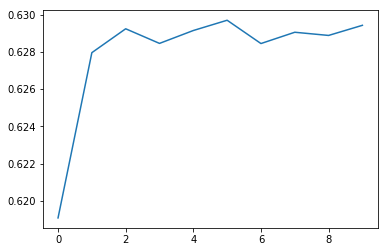

In [9]:
# plot metrics
pyplot.plot(history.history['categorical_accuracy'])
pyplot.show()

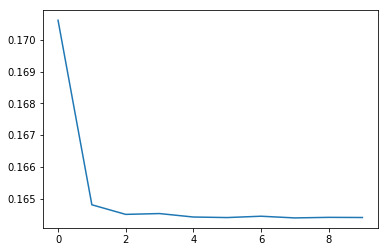

In [10]:
# plot metrics
pyplot.plot(history.history['mean_absolute_error'])
pyplot.show()

In [11]:
#####################################################################
# Validate that models predicts well
#####################################################################
generated = ''
sentence = ' ca'
generated += sentence
print('----- Generating with seed: "' + sentence + '"')

x_pred = np.zeros((1, maxlen, len(chars)))
for t, char in enumerate(sentence):
    x_pred[0, t, char_indices[char]] = 1.

preds = model.predict(x_pred, verbose=0)[0]
print("preds =", preds)
next_index = sample(preds, 0.001)
next_char = indices_char[next_index]

sys.stdout.write("next_char = {} \n".format(next_char))


----- Generating with seed: " ca"
preds = [1.04362605e-16 7.33878791e-11 7.40383664e-16 4.34949358e-13
 1.00000000e+00]
next_char = t 


In [0]:
#####################################################################
#    Save model
#####################################################################
model.save('model_train{}_alphabet{}_x{}.h5'.format(n_words_in_corpus, sizeAlphabet, sizeX))

In [13]:
#####################################################################
#    Create StateTransition System from RNN
#####################################################################

# I. Create Graph Structure (using only metadata of the network)
#------------------------------------------------------------------------------

# G is the graph constructed from RNN Inputs
G = nx.balanced_tree(r=sizeAlphabet, h=sizeX)
f = Digraph('balanced_tree', filename='balanced_'+str(sizeX)+'_'+str(sizeAlphabet)+'.gv')
f.attr(rankdir='LR', size='8,5')

for b_node in G.nodes:
    f.node("S"+str(b_node), H="", Y="")

for i, b_edge in enumerate(G.edges):
    label = alphabet[i%sizeAlphabet]
    f.edge("S"+str(b_edge[0]), "S"+str(b_edge[1]), label)
    
# II. Create Attributes Empty and assign to the nodes
#------------------------------------------------------------------------------

labels = {}
rnn_states = {}

r = sizeAlphabet
h = sizeX

# root:
state_placeholder = np.array([])
rnn_states[0] = state_placeholder  # state will contain rnn H and Y of the model
next_node_id = 1

for level in range(1,h+1):
  print("Tree level:", level)  
  elemnts_count = pow(r,level)
  print("elemnts_count = ", elemnts_count)
  
  print("Nodes btw :", next_node_id, " and ", next_node_id + elemnts_count)
  for node_id in range(next_node_id,  next_node_id + elemnts_count): 
    rnn_states[node_id] = state_placeholder
    labels[node_id] = alphabet[node_id%sizeAlphabet]
  next_node_id = node_id+1
  print("next_node_id = ", next_node_id)

nx.set_node_attributes(G, labels, 'label')
nx.set_node_attributes(G, rnn_states, 'rnn_state')

# III. Get x per node
#------------------------------------------------------------------------------

x_val = {}
above_labels = {}

for node_id in G.nodes:
  node = G.nodes[node_id]
  print("node_id=",node_id, " node = ",node)
  shortest_path = nx.shortest_path(G, source=0, target=node_id)
  above_labels_str = ""
  for j in shortest_path[1:]:
    above_labels_str = above_labels_str + G.nodes[j]['label']
  print("above_labels_str = ", above_labels_str)
  
  
  if 'label' in node.keys():
    label = node['label']
    print("label = ", label)
    above_labels[node_id] = above_labels_str
    
    if len(above_labels_str) <= maxlen:
      x_val[node_id] = sentence_to_code(above_labels_str, char_indices, maxlen, sizeAlphabet)
    else:
      x_val[node_id] =np.array([])
nx.set_node_attributes(G, above_labels, 'above_labels')
nx.set_node_attributes(G, x_val, 'x_val')

# IV. Get y per node
#------------------------------------------------------------------------------
y_val = {}
for node in G.nodes():
  if 'x_val' in  G.nodes[node].keys():
    x_val_node = G.nodes[node]['x_val']
    y_val_node = model.predict(x_val_node, verbose=0)[0]
    y_val[node] = y_val_node
nx.set_node_attributes(G, y_val, 'y_val')

# IV. Calculate hidden states per node
#------------------------------------------------------------------------------
for layer in model.layers:
        if "LSTM" in str(layer):
            weightLSTM = layer.get_weights()
warr,uarr, barr = weightLSTM
warr.shape,uarr.shape,barr.shape


def get_hidden_states_keras(model, xs, sizeX, sizeAlphabet, lstm_hunits):
  batch_size = 1
  len_ts = sizeX
  nfeature = sizeAlphabet
  inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                         name="input")  
  rnn,s,c = layers.LSTM(lstm_hunits, 
                           return_sequences=True,
                           stateful=False,
                           return_state=True,
                           name="RNN")(inp)
  states = models.Model(inputs=[inp],outputs=[s,c, rnn])
  for layer in states.layers:
      for layer1 in model.layers:
          if layer.name == layer1.name:
              layer.set_weights(layer1.get_weights())
  h_t_keras, c_t_keras, rnn = states.predict(xs.reshape(1,len_ts,5))  
  return (h_t_keras, c_t_keras)


# # Example:

# xs = np.array([[[0., 0., 0., 0., 1.],
#         [1., 0., 0., 0., 0.],
#         [0., 0., 0., 0., 0.]]])
# tmp = get_hidden_states_keras(model, xs, sizeX, sizeAlphabet, lstm_hunits)
# print("tmp ={}".format(tmp))



h_val = {}
for node in G.nodes():
  if 'x_val' in  G.nodes[node].keys():
    x_val_node = G.nodes[node]['x_val']
    h_val_node = get_hidden_states_keras(model, x_val_node, sizeX, sizeAlphabet, lstm_hunits)
    h_val[node] = h_val_node
    
nx.set_node_attributes(G, h_val, 'h_val')

Tree level: 1
elemnts_count =  5
Nodes btw : 1  and  6
next_node_id =  6
Tree level: 2
elemnts_count =  25
Nodes btw : 6  and  31
next_node_id =  31
Tree level: 3
elemnts_count =  125
Nodes btw : 31  and  156
next_node_id =  156
node_id= 0  node =  {'rnn_state': array([], dtype=float64)}
above_labels_str =  
node_id= 1  node =  {'label': 'a', 'rnn_state': array([], dtype=float64)}
above_labels_str =  a
label =  a
node_id= 2  node =  {'label': 't', 'rnn_state': array([], dtype=float64)}
above_labels_str =  t
label =  t
node_id= 3  node =  {'label': 'e', 'rnn_state': array([], dtype=float64)}
above_labels_str =  e
label =  e
node_id= 4  node =  {'label': ' ', 'rnn_state': array([], dtype=float64)}
above_labels_str =   
label =   
node_id= 5  node =  {'label': 'c', 'rnn_state': array([], dtype=float64)}
above_labels_str =  c
label =  c
node_id= 6  node =  {'label': 'a', 'rnn_state': array([], dtype=float64)}
above_labels_str =  aa
label =  a
node_id= 7  node =  {'label': 't', 'rnn_state':

In [14]:
#####################################################################
#    Ground truth property satisfaction
#####################################################################
total_combinations = len(G.nodes()) # total nodes
n_satisfy = 0
# calculate Property rate over ground truth Graph
for node in G.nodes():
  if 'y_val' in  G.nodes[node].keys():
    y_val_node = G.nodes[node]['y_val']
    if any(y_val_node>0.8):
      n_satisfy = n_satisfy + 1
gt_satisfy = n_satisfy/total_combinations
print("Ground truth property satisfaction rate:{}".format(gt_satisfy)) 

Ground truth property satisfaction rate:0.5641025641025641


In [15]:
####################################################
#  TensorSMC
####################################################
alpha = 1 
beta = 1 

smc_satisfy_rates = []
smc_ro_estimates = []
smc_nu_estimates = []
increasing_samples  = range(1, total_combinations, 5)

for j in increasing_samples:
  n_trajectories = 0   # number trajectories drawn so far
  n_satisfy = 0     # number of trajectories satisfying property so far

  for n_trajectories in range(0,j+1):
    index_rand = random.randrange(total_combinations)
    if 'y_val' in  G.nodes[index_rand].keys():
      y_val_node = G.nodes[index_rand]['y_val']
      if any(y_val_node>0.8):
        n_satisfy = n_satisfy + 1
  print("n_satisfy={}, n_trajectories={}".format(n_satisfy, n_trajectories))
  print("SMC property satisfaction rate:{}".format(n_satisfy/n_trajectories)) 
  ro = (n_satisfy + alpha)/(n_trajectories + alpha + beta)
  nu = np.sqrt(((alpha + n_satisfy)*(n_trajectories - n_satisfy + beta)) / (pow((alpha + n_trajectories + beta),2)*(alpha + n_trajectories + beta + 1)))
  print("Estiamted property satisfaction:{} +/- {}".format(ro, nu)) 
  smc_satisfy_rates.append(n_satisfy/n_trajectories)
  smc_ro_estimates.append(ro)
  smc_nu_estimates.append(nu)



n_satisfy=1, n_trajectories=1
SMC property satisfaction rate:1.0
Estiamted property satisfaction:0.6666666666666666 +/- 0.23570226039551584
n_satisfy=5, n_trajectories=6
SMC property satisfaction rate:0.8333333333333334
Estiamted property satisfaction:0.75 +/- 0.14433756729740643
n_satisfy=4, n_trajectories=11
SMC property satisfaction rate:0.36363636363636365
Estiamted property satisfaction:0.38461538461538464 +/- 0.13002373149669486
n_satisfy=10, n_trajectories=16
SMC property satisfaction rate:0.625
Estiamted property satisfaction:0.6111111111111112 +/- 0.11183971636786712
n_satisfy=13, n_trajectories=21
SMC property satisfaction rate:0.6190476190476191
Estiamted property satisfaction:0.6086956521739131 +/- 0.09962121075990957
n_satisfy=18, n_trajectories=26
SMC property satisfaction rate:0.6923076923076923
Estiamted property satisfaction:0.6785714285714286 +/- 0.0867243442928978
n_satisfy=22, n_trajectories=31
SMC property satisfaction rate:0.7096774193548387
Estiamted property sat

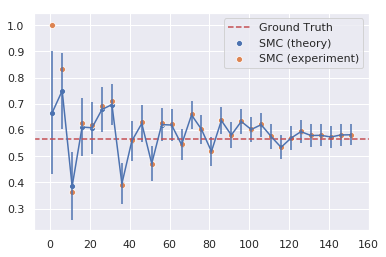

In [16]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
ax = sns.scatterplot(x=increasing_samples, y=smc_ro_estimates)
ax.errorbar(increasing_samples, smc_ro_estimates, yerr=smc_nu_estimates)
sns.scatterplot(x=increasing_samples, y=smc_satisfy_rates, ax = ax)
ax.axhline(gt_satisfy, ls='--', color='r')
ax.legend(labels=['Ground Truth', 'SMC (theory)', 'SMC (experiment)'])

In [0]:
f